<a href="https://colab.research.google.com/github/ChiragShetye/Zee-Recommender-System/blob/main/Zee_Recommendation_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.impute import KNNImputer
from collections import defaultdict
from scipy import sparse
!pip install scikit-surprise
from surprise import SVD
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate
from scipy.stats import pearsonr
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
import warnings
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 10.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp311-cp311-linux_x86_64.whl size=2505186 sha256=a88339519de9f7df9250dd9e9951fbd8562b20d12e7e3e647b99fcc6d6a02df4
  Stored in directory: /root/.cache/pip/wheels/2a/8f/6e/7e2899163e2d85d8266daab4aa1cdabec7a6c56f83c015b5af
Successfully built scikit-surprise


In [ ]:
movies = pd.read_fwf("zee-movies.dat",encoding="ISO-8859-1")
ratings =pd.read_fwf("zee-ratings.dat",encoding="ISO-8859-1")
users = pd.read_fwf("zee-users.dat",encoding="ISO-8859-1")

### 🚀 Exploratory Data Analysis & Feature Engineering


In [ ]:
rows, columns = movies.shape
print(f'Rows in the Movies dataset: {rows}')
print(f'Columns in the Movies dataset: {columns}')
movies.info()
movies.drop(columns=['Unnamed: 1','Unnamed: 2'],inplace=True)
delimeter = "::"
movies = movies['Movie ID::Title::Genres'].str.split(delimeter,expand=True)
movies.columns = ['MovieID','Title','Genres']
movies.describe()
movies.sample(5)

Rows in the Movies dataset: 3883
Columns in the Movies dataset: 3
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3883 entries, 0 to 3882
Data columns (total 3 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Movie ID::Title::Genres  3883 non-null   object
 1   Unnamed: 1               100 non-null    object
 2   Unnamed: 2               51 non-null     object
dtypes: object(3)
memory usage: 91.1+ KB


,MovieID,Title,Genres
1263,1283,High Noon (1952),Western
3628,3697,Predator 2 (1990),Action|Sci-Fi|Thriller
2978,3047,Experience Preferred... But Not Essential (1982),Drama
3191,3260,Howards End (1992),Drama
3013,3082,"World Is Not Enough, The (1999)",Action|Thriller


In [ ]:
rows, columns = ratings.shape
print(f'Rows in the Ratings dataset: {rows}')
print(f'Columns in the Ratings dataset: {columns}')
ratings.info()
delimeter = "::"
ratings = ratings['UserID::MovieID::Rating::Timestamp'].str.split(delimeter,expand=True)
ratings.columns = ['UserID','MovieID','Rating','Timestamp']
ratings.sample(5)

Rows in the Ratings dataset: 1000209
Columns in the Ratings dataset: 1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 1 columns):
 #   Column                              Non-Null Count    Dtype 
---  ------                              --------------    ----- 
 0   UserID::MovieID::Rating::Timestamp  1000209 non-null  object
dtypes: object(1)
memory usage: 7.6+ MB


,UserID,MovieID,Rating,Timestamp
394022,2321,539,4,974496337
298246,1767,1221,5,975386494
802506,4808,2163,3,962952528
369924,2164,1333,4,974614724
536161,3308,1911,4,967978723


In [ ]:
rows, columns = users.shape
print(f'Rows in the Users dataset: {rows}')
print(f'Columns in the Users dataset: {columns}')
users.info()
delimeter = "::"
users = users['UserID::Gender::Age::Occupation::Zip-code'].str.split(delimeter,expand=True)
users.columns = ['UserID','Gender','Age','Occupation','Zip-code']
users.sample(5)

Rows in the Users dataset: 6040
Columns in the Users dataset: 1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6040 entries, 0 to 6039
Data columns (total 1 columns):
 #   Column                                     Non-Null Count  Dtype 
---  ------                                     --------------  ----- 
 0   UserID::Gender::Age::Occupation::Zip-code  6040 non-null   object
dtypes: object(1)
memory usage: 47.3+ KB


,UserID,Gender,Age,Occupation,Zip-code
2486,2487,M,45,7,55438
4067,4068,M,56,3,89185
898,899,F,25,1,30605
5507,5508,M,25,20,94519
2350,2351,F,25,0,11106


###functools.reduce() to merge multiple DataFrames efficiently in a loop-like fashion.

In [ ]:
from functools import reduce
dfs = [movies, ratings, users]
df = reduce(lambda left, right: pd.merge(left, right, on=left.columns.intersection(right.columns).tolist(), how='inner'), dfs)
rows, columns = df.shape
print(f'Rows in the dataset: {rows}')
print(f'Columns in the dataset: {columns}')
df.sample(10)

Rows in the dataset: 1000209
Columns in the dataset: 10


,MovieID,Title,Genres,UserID,Rating,Timestamp,Gender,Age,Occupation,Zip-code
778469,2902,Psycho II (1983),Horror|Thriller,5954,4,957705713,M,45,11,70802
133546,492,Manhattan Murder Mystery (1993),Comedy|Mystery,2168,5,975705313,M,1,10,60202
654827,2405,"Jewel of the Nile, The (1985)",Action|Adventure|Comedy|Romance,3601,3,966642026,F,35,3,95405
876568,3300,Pitch Black (2000),Action|Sci-Fi,506,4,976208133,M,25,16,55103-1006
307392,1201,"Good, The Bad and The Ugly, The (1966)",Action|Western,4502,4,965096719,M,50,0,01379
487783,1747,Wag the Dog (1997),Comedy|Drama,326,3,976423018,M,50,11,25302
583015,2118,"Dead Zone, The (1983)",Horror|Thriller,5684,5,958605484,M,18,16,94110
678386,2498,My Favorite Martian (1999),Comedy|Sci-Fi,2541,3,974047943,F,35,5,49424
647111,2391,"Simple Plan, A (1998)",Crime|Thriller,5526,1,959634461,F,35,2,27514
100657,360,I Love Trouble (1994),Action|Comedy,3526,3,966908091,M,35,2,62263-3004


In [ ]:
df.shape

(1000209, 10)

In [ ]:
df = df.astype({'Age': 'int32', 'Rating': 'int32'})  # Convert age & ratings to integer
df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='s')  # Convert Unix timestamp to datetime
df['ReleaseYear'] = df['Title'].str.extract(r'\((\d{4})\)$')[0]
df.sample(10)

,MovieID,Title,Genres,UserID,Rating,Timestamp,Gender,Age,Occupation,Zip-code,ReleaseYear
266909,1088,Dirty Dancing (1987),Musical|Romance,3087,5,2000-09-23 04:14:28,F,1,1,90802,1987
454687,1610,"Hunt for Red October, The (1990)",Action|Thriller,5653,4,2000-05-20 21:57:30,M,50,1,74105,1990
55862,207,"Walk in the Clouds, A (1995)",Drama|Romance,2371,4,2000-11-16 01:31:40,F,35,7,06082,1995
898651,3424,Do the Right Thing (1989),Comedy|Drama,457,5,2000-12-08 00:17:51,M,18,4,54703,1989
435071,1535,Love! Valour! Compassion! (1997),Drama|Romance,331,4,2001-01-07 16:14:21,M,25,7,55902,1997
415500,1397,Bastard Out of Carolina (1996),Drama,4425,2,2000-08-01 05:15:24,M,35,7,98607,1996
56483,208,Waterworld (1995),Action|Adventure,4425,3,2000-08-01 06:40:41,M,35,7,98607,1995
507755,1895,Can't Hardly Wait (1998),Comedy|Drama|Romance,877,3,2000-11-26 20:34:59,M,25,0,90631,1998
244106,1011,Herbie Rides Again (1974),Adventure|Children's|Comedy,2064,1,2000-11-19 20:42:16,M,35,1,01020,1974
274813,1097,E.T. the Extra-Terrestrial (1982),Children's|Drama|Fantasy|Sci-F,3346,4,2000-09-01 02:47:10,M,35,7,54016,1982


In [ ]:
bins = [0, 17, 24, 34, 44, 49, 55, float('inf')]
labels = ["Under 18", "18-24", "25-34", "35-44", "45-49", "50-55", "56+"]
df['Age'] = pd.cut(df['Age'], bins=bins, labels=labels, right=True)

In [ ]:
occupation_mapping = {
    '0': "other",
    '1': "academic/educator",
    '2': "artist",
    '3': "clerical/admin",
    '4': "college/grad student",
    '5': "customer service",
    '6': "doctor/health care",
    '7': "executive/managerial",
    '8': "farmer",
    '9': "homemaker",
    '10': "K-12 student",
    '11': "lawyer",
    '12': "programmer",
    '13': "retired",
    '14': "sales/marketing",
    '15': "scientist",
    '16': "self-employed",
    '17': "technician/engineer",
    '18': "tradesman/craftsman",
    '19': "unemployed",
    '20': "writer"
}

df['Occupation'] = df['Occupation'].astype(str).map(occupation_mapping).fillna("other")
df.sample(10)

,MovieID,Title,Genres,UserID,Rating,Timestamp,Gender,Age,Occupation,Zip-code,ReleaseYear
703723,2617,"Mummy, The (1999)",Action|Adventure|Horror|Thriller,3507,4,2000-08-23 21:46:37,M,25-34,other,02472,1999
786676,2926,Hairspray (1988),Comedy|Drama,1749,3,2000-11-21 20:47:13,M,25-34,artist,10040,1988
823951,3072,Moonstruck (1987),Comedy,5312,4,2000-07-27 03:35:24,M,25-34,academic/educator,10463,1987
841845,3147,"Green Mile, The (1999)",Drama|Thriller,4587,3,2000-07-23 01:31:51,M,35-44,sales/marketing,07920,1999
678669,2501,October Sky (1999),Drama,424,4,2001-08-14 02:10:58,M,25-34,technician/engineer,55112,1999
234559,945,Top Hat (1935),Comedy|Musical|Romance,830,4,2000-11-27 23:34:14,M,35-44,executive/managerial,60657,1935
352487,1261,Evil Dead II (Dead By Dawn) (1987),Action|Adventure|Comedy|Horro,4298,3,2000-08-03 02:25:57,F,18-24,sales/marketing,85705,1987
605086,2215,Rich and Strange (1932),Comedy|Romance,731,4,2000-11-29 20:41:31,M,45-49,clerical/admin,55410,1932
819438,3053,"Messenger: The Story of Joan of Arc, The (1999)",Drama|War,4042,4,2000-12-03 02:32:15,M,35-44,scientist,94002,1999
434424,1527,"Fifth Element, The (1997)",Action|Sci-Fi,3652,4,2002-04-17 19:38:51,M,25-34,programmer,94608,1997


In [ ]:
df['ReleaseYear'].unique()

array(['1995', '1994', '1996', nan, '1976', '1993', '1992', '1988',
       '1967', '1977', '1965', '1982', '1962', '1990', '1991', '1989',
       '1937', '1940', '1969', '1981', '1973', '1970', '1960', '1955',
       '1956', '1959', '1968', '1980', '1975', '1948', '1943', '1950',
       '1987', '1997', '1974', '1958', '1972', '1998', '1952', '1951',
       '1957', '1961', '1954', '1934', '1944', '1963', '1942', '1941',
       '1964', '1953', '1939', '1947', '1946', '1945', '1938', '1935',
       '1936', '1926', '1949', '1932', '1930', '1971', '1979', '1986',
       '1966', '1978', '1985', '1983', '1984', '1933', '1931', '1922',
       '1927', '1929', '1928', '1999', '1925', '1919', '1923', '2000',
       '1920', '1921'], dtype=object)

###KNN for missing values in Released Year

In [ ]:
# Convert 'ReleaseYear' to numeric
df['ReleaseYear'] = pd.to_numeric(df['ReleaseYear'], errors='coerce')

# Columns to use for KNN (excluding categorical ones)
numeric_cols = df.select_dtypes(include=[np.number]).columns

# KNN imputer
knn_imputer = KNNImputer(n_neighbors=3)

# Apply KNN
df[numeric_cols] = knn_imputer.fit_transform(df[numeric_cols])

# Convert ReleaseYear back to integer (since KNN outputs floats)
df['ReleaseYear'] = df['ReleaseYear'].astype(int)


In [ ]:
df['ReleaseYear'].unique()

array([1995, 1994, 1996, 1976, 1993, 1992, 1988, 1967, 1977, 1965, 1982,
       1962, 1990, 1991, 1989, 1937, 1940, 1969, 1981, 1973, 1970, 1960,
       1955, 1956, 1959, 1968, 1980, 1975, 1948, 1943, 1950, 1987, 1997,
       1974, 1958, 1972, 1998, 1952, 1951, 1957, 1961, 1954, 1934, 1944,
       1963, 1942, 1941, 1964, 1953, 1939, 1947, 1946, 1945, 1938, 1935,
       1936, 1926, 1949, 1932, 1930, 1971, 1979, 1986, 1966, 1978, 1985,
       1983, 1984, 1933, 1931, 1922, 1927, 1929, 1928, 1999, 1925, 1919,
       1923, 2000, 1920, 1921])

In [ ]:
df['Cleaned_Title'] = df['Title'].str.replace(r'\(\d{4}\)', '', regex=True).str.strip()

In [ ]:
df.sample(10)

,MovieID,Title,Genres,UserID,Rating,Timestamp,Gender,Age,Occupation,Zip-code,ReleaseYear,Cleaned_Title
537904,1994,Poltergeist (1982),Horror|Thriller,4575,1.0,2000-07-24 13:37:14,F,Under 18,K-12 student,03608,1982,Poltergeist
268893,1090,Platoon (1986),Drama|War,2119,4.0,2000-11-20 13:50:31,M,35-44,college/grad student,10036,1986,Platoon
200493,800,Lone Star (1996),Drama|Mystery,2174,3.0,2000-11-19 05:38:55,M,50-55,programmer,87505,1996,Lone Star
57203,216,Billy Madison (1995),Comedy,1737,3.0,2000-12-16 22:17:10,M,35-44,writer,46614,1995,Billy Madison
340717,1245,Miller's Crossing (1990),Drama,482,4.0,2001-10-03 04:35:22,M,25-34,sales/marketing,55305,1990,Miller's Crossing
288708,1173,"Cook the Thief His Wife & Her Lover, The (1989)",Drama,2895,4.0,2000-10-19 21:24:05,M,25-34,lawyer,07039,1989,"Cook the Thief His Wife & Her Lover, The"
539833,2000,Lethal Weapon (1987),Action|Comedy|Crime|Drama,1319,4.0,2000-11-21 03:51:54,F,25-34,clerical/admin,98626,1987,Lethal Weapon
640213,2367,King Kong (1976),Action|Adventure|Horror,3834,5.0,2000-08-16 04:04:07,M,18-24,artist,02322,1976,King Kong
458292,1617,L.A. Confidential (1997),Crime|Film-Noir|Mystery|Thriller,5597,2.0,2000-05-25 00:49:34,F,18-24,college/grad student,95008,1997,L.A. Confidential
193699,765,Jack (1996),Comedy|Drama,2188,3.0,2000-11-19 06:05:39,F,18-24,unemployed,60641,1996,Jack


###🔹 Explanation of the Regular Expression
*   ^(.*), (The|A|An)$
* (.*): Captures everything before the comma.
*  (The|A|An): Matches ", The", ", A", or ", An" at the end of the title.
*   List item
The function swaps the position of these words.

In [ ]:
def fix_title(title):
    match = re.match(r'^(.*), (The|A|An)$', title)
    if match:
        return f"{match.group(2)} {match.group(1)}"
    return title

df['Cleaned_Title'] = df['Cleaned_Title'].apply(fix_title)
df.drop(columns=['Title'],inplace=True)

In [ ]:
df.sample(15)

,MovieID,Genres,UserID,Rating,Timestamp,Gender,Age,Occupation,Zip-code,ReleaseYear,Cleaned_Title
642978,2375,Comedy,4821,2.0,2000-07-07 05:11:15,M,18-24,unemployed,75080,1986,The Money Pit
525308,1957,Drama,1861,4.0,2000-11-20 05:14:28,M,50-55,self-employed,92129,1981,Chariots of Fire
112801,412,Drama,5111,3.0,2000-07-01 04:50:05,M,35-44,artist,78006,1993,The Age of Innocence
779590,2908,Drama,3280,3.0,2000-09-05 15:50:18,M,25-34,executive/managerial,33486,1999,Boys Don't Cry
261082,1073,Adventure|Children',5475,5.0,2001-07-10 06:59:56,M,25-34,college/grad student,94110,1971,Willy Wonka and the Chocolate Factory
340415,1244,Comedy|Drama|Romance,3940,5.0,2000-08-08 00:48:17,M,35-44,writer,32708,1979,Manhattan
893868,3408,Drama,2374,3.0,2000-11-16 00:43:48,M,25-34,sales/marketing,94404,2000,Erin Brockovich
373968,1291,Action|Adventure,4213,5.0,2000-08-09 18:45:18,M,35-44,executive/managerial,63125,1989,Indiana Jones and the Last Crusade
453839,1610,Action|Thriller,2641,3.0,2000-11-07 04:05:30,M,25-34,doctor/health care,19428,1990,The Hunt for Red October
603652,2194,Action|Crime|Drama,5684,5.0,2000-05-17 23:31:34,M,18-24,self-employed,94110,1987,The Untouchables


In [ ]:
# Display only columns with missing values
missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0]  # Filter non-zero missing values

print("Missing Values in Each Column:")
print(missing_values)

Missing Values in Each Column:
Genres    4065
dtype: int64


In [ ]:
# Count duplicate rows directly
num_duplicates = df.duplicated().sum()

# Print the result
print(f'The number of duplicate rows: {num_duplicates}')


The number of duplicate rows: 0


In [ ]:
df['Genres'] = df.groupby('Cleaned_Title')['Genres'].transform(lambda x: x.fillna(x.mode()[0]) if not x.mode().empty else "Unknown")

In [ ]:
df.isnull().sum()

,0
MovieID,0
Genres,0
UserID,0
Rating,0
Timestamp,0
Gender,0
Age,0
Occupation,0
Zip-code,0
ReleaseYear,0


### Univariate & BiVariant analysis

In [ ]:
df['Decade'] = df['ReleaseYear'].apply(lambda x: f"'{str(x // 10 * 10)[2:]}s")
most_common_decade = df['Decade'].value_counts().idxmax()
print(f"Most movies were released in the {most_common_decade}'")

Most movies were released in the '90s'


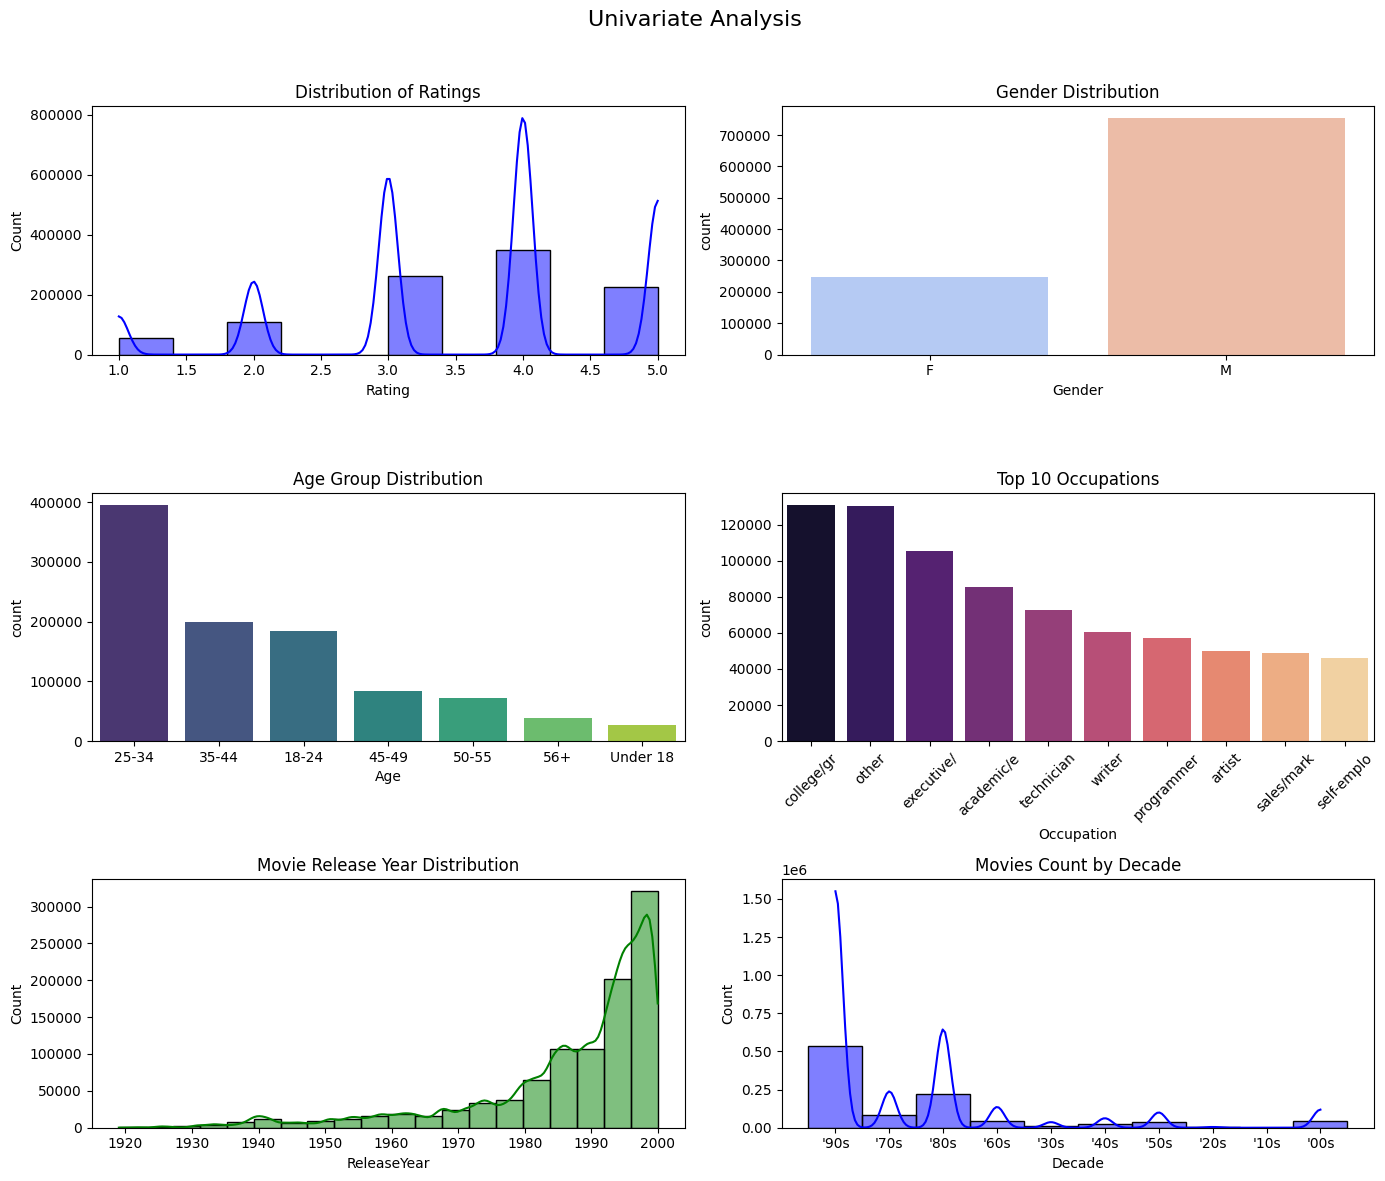

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(14, 12))
fig.suptitle("Univariate Analysis", fontsize=16)

# Histogram of Ratings
sns.histplot(df['Rating'], bins=10, kde=True, ax=axes[0,0], color='blue')
axes[0,0].set_title('Distribution of Ratings')

# Countplot of Gender
sns.countplot(x=df['Gender'], ax=axes[0,1], palette='coolwarm')
axes[0,1].set_title('Gender Distribution')

# Countplot of Age Group
sns.countplot(x=df['Age'], order=df['Age'].value_counts().index, ax=axes[1,0], palette='viridis')
axes[1,0].set_title('Age Group Distribution')

# Countplot of Top 10 Occupations
sns.countplot(x=df['Occupation'], order=df['Occupation'].value_counts().index[:10], ax=axes[1,1], palette='magma')
axes[1,1].set_title('Top 10 Occupations')
x_labels = [label.get_text()[:10] for label in axes[1,1].get_xticklabels()]
axes[1,1].set_xticklabels(x_labels, rotation=45)

# Histogram of Movie Release Year
sns.histplot(df['ReleaseYear'], bins=20, kde=True, ax=axes[2,0], color='green')
axes[2,0].set_title('Movie Release Year Distribution')

# Histogram of Movies Count by Decade
sns.histplot(df['Decade'], bins=10, kde=True, ax=axes[2,1], color='blue')
axes[2,1].set_title('Movies Count by Decade')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


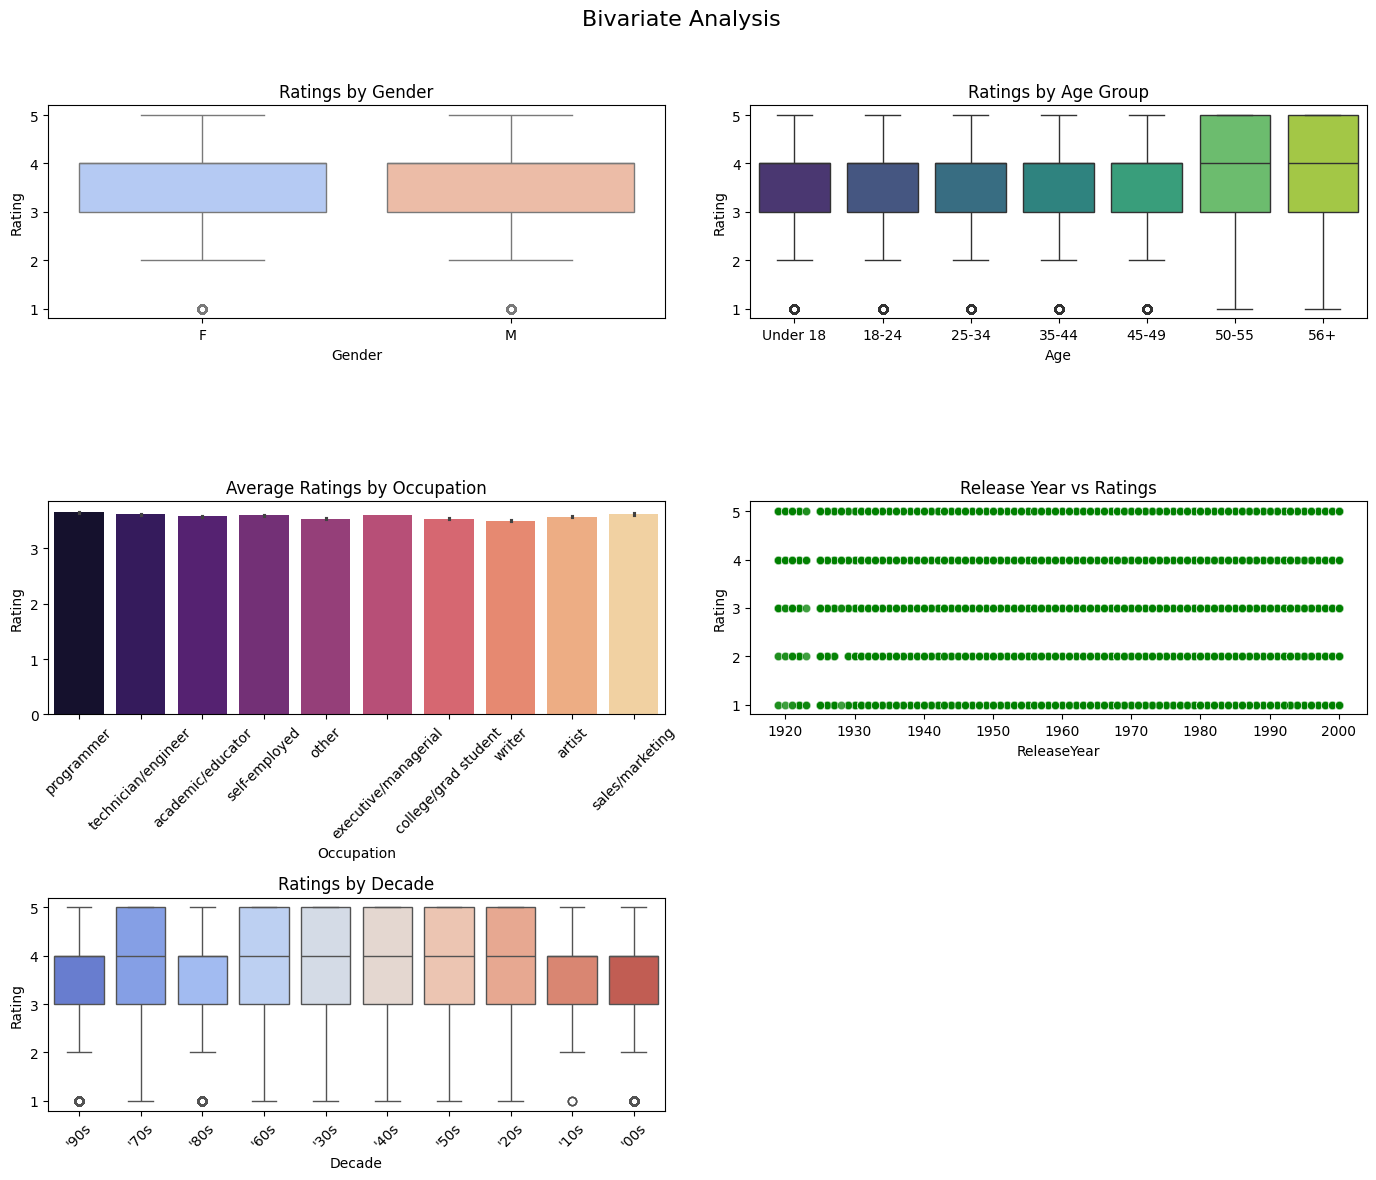

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(14, 12))
fig.suptitle("Bivariate Analysis", fontsize=16)

# Boxplot of Ratings vs Gender
sns.boxplot(x='Gender', y='Rating', data=df, ax=axes[0,0], palette='coolwarm')
axes[0,0].set_title('Ratings by Gender')

# Boxplot of Ratings vs Age Group
sns.boxplot(x='Age', y='Rating', data=df, ax=axes[0,1], palette='viridis')
axes[0,1].set_title('Ratings by Age Group')

# Barplot of Average Ratings by Top 10 Occupations
top_occupations = df['Occupation'].value_counts().index[:10]
df_filtered = df[df['Occupation'].isin(top_occupations)]
sns.barplot(x='Occupation', y='Rating', data=df_filtered, ax=axes[1,0], palette='magma', estimator=np.mean)
axes[1,0].set_title('Average Ratings by Occupation')
axes[1,0].tick_params(axis='x', rotation=45)

# Scatterplot of Release Year vs Ratings
sns.scatterplot(x='ReleaseYear', y='Rating', data=df, ax=axes[1,1], color='green', alpha=0.5)
axes[1,1].set_title('Release Year vs Ratings')

# Boxplot of Ratings by Decade
sns.boxplot(x='Decade', y='Rating', data=df, ax=axes[2,0], palette='coolwarm')
axes[2,0].set_title('Ratings by Decade')
axes[2,0].tick_params(axis='x', rotation=45)

axes[2,1].axis("off")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

###Answering the basic questions

1. Users of which age group have watched and rated the most number of movies?



The age group that has rated the most movies is: 25-34


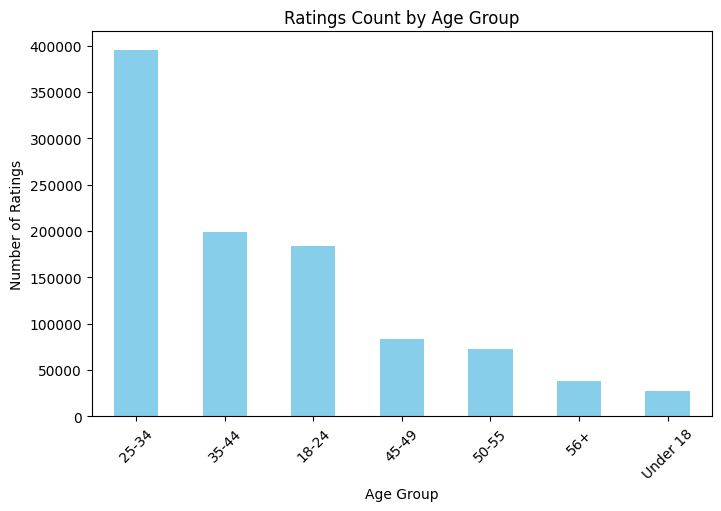

In [ ]:
# The number of ratings by age group
age_group_ratings = df.groupby('Age')['Rating'].count()

# The age group with the highest count
most_active_age_group = age_group_ratings.idxmax()
print(f"The age group that has rated the most movies is: {most_active_age_group}")

plt.figure(figsize=(8,5))
age_group_ratings.sort_values(ascending=False).plot(kind='bar', color='skyblue')
plt.xlabel("Age Group")
plt.ylabel("Number of Ratings")
plt.title("Ratings Count by Age Group")
plt.xticks(rotation=45)
plt.show()


###2. Users belonging to which profession have watched and rated the most movies?

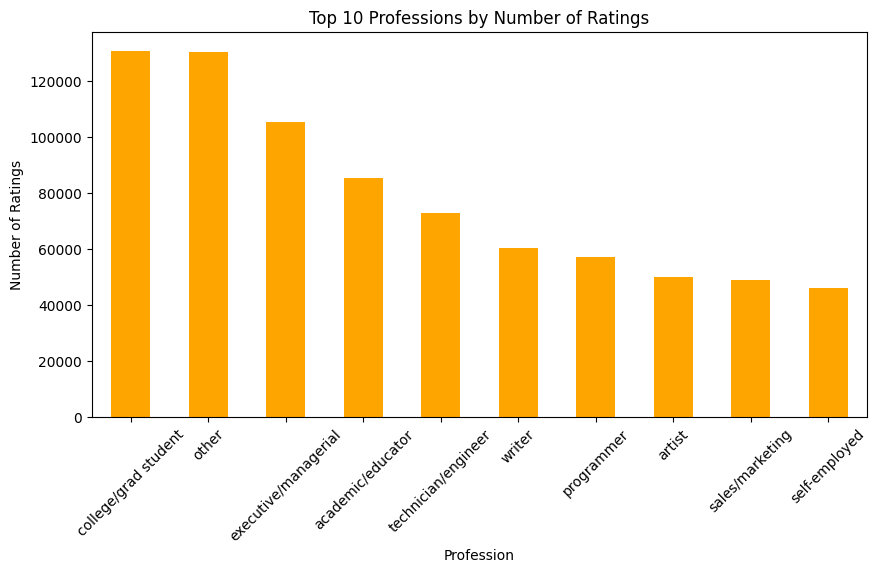

In [ ]:
# The number of ratings by profession
profession_ratings = df.groupby('Occupation')['Rating'].count()

# The top 10 professions
top_10_professions = profession_ratings.sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 5))
top_10_professions.plot(kind='bar', color='orange')
plt.xlabel("Profession")
plt.ylabel("Number of Ratings")
plt.title("Top 10 Professions by Number of Ratings")
plt.xticks(rotation=45)
plt.show()

3. Most of the users in our dataset who’ve rated the movies are Male. (T/F)

In [ ]:
# Count the number of ratings by gender
gender_ratings = df.groupby('Gender')['Rating'].count()

# Which gender has more ratings
most_rated_gender = gender_ratings.idxmax()
print(f"Most of the users who rated movies are {most_rated_gender}.")

Most of the users who rated movies are M.


4. Most of the movies present in our dataset were released in which decade?

70s b. 90s c. 50s d.80s

Most movies were released in the '90s'


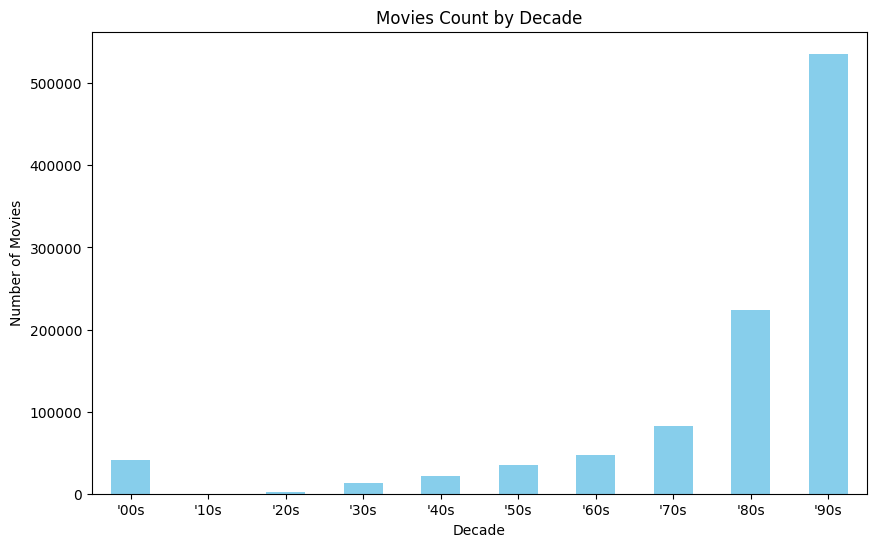

In [ ]:
df['Decade'] = df['ReleaseYear'].apply(lambda x: f"'{str(x // 10 * 10)[2:]}s")
most_common_decade = df['Decade'].value_counts().idxmax()
print(f"Most movies were released in the {most_common_decade}'")

plt.figure(figsize=(10,6))
df['Decade'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.xlabel("Decade")
plt.ylabel("Number of Movies")
plt.title("Movies Count by Decade")
plt.xticks(rotation=0)
plt.show()

###5. Find the movie with the highest number of ratings


In [ ]:
top_movie = df.groupby('Cleaned_Title')['Rating'].count().idxmax()
top_movie_ratings = df.groupby('Cleaned_Title')['Rating'].count().max()

print(f"The movie with the maximum number of ratings is: {top_movie} with {top_movie_ratings} ratings.")


The movie with the maximum number of ratings is: American Beauty with 3428 ratings.


## 🚀 Model Building: Recommendation System

In [ ]:
df

,MovieID,Genres,UserID,Rating,Timestamp,Gender,Age,Occupation,Zip-code,ReleaseYear,Cleaned_Title,Decade
0,1,Animation|Children's|Comedy,1,5.0,2001-01-06 23:37:48,F,Under 18,K-12 student,48067,1995,Toy Story,'90s
1,1,Animation|Children's|Comedy,6,4.0,2000-12-31 04:30:08,F,50-55,homemaker,55117,1995,Toy Story,'90s
2,1,Animation|Children's|Comedy,8,4.0,2000-12-31 03:31:36,M,25-34,programmer,11413,1995,Toy Story,'90s
3,1,Animation|Children's|Comedy,9,5.0,2000-12-31 01:25:52,M,25-34,technician/engineer,61614,1995,Toy Story,'90s
4,1,Animation|Children's|Comedy,10,5.0,2000-12-31 01:34:34,F,35-44,academic/educator,95370,1995,Toy Story,'90s
...,...,...,...,...,...,...,...,...,...,...,...,...
1000204,3952,Drama|Thriller,5812,4.0,2001-06-09 07:34:59,F,25-34,executive/managerial,92120,2000,The Contender,'00s
1000205,3952,Drama|Thriller,5831,3.0,2001-04-02 14:52:05,M,25-34,academic/educator,92120,2000,The Contender,'00s
1000206,3952,Drama|Thriller,5837,4.0,2002-01-24 20:04:16,M,25-34,executive/managerial,60607,2000,The Contender,'00s
1000207,3952,Drama|Thriller,5927,1.0,2001-01-18 21:15:37,M,35-44,sales/marketing,10003,2000,The Contender,'00s


## Build a Recommender System based on Pearson Correlation.


### Item - Item Approach

In [ ]:
# Creating a user-movie matrix
movie_pivot = df.pivot_table(index="Cleaned_Title", columns="UserID", values="Rating")

# Fill NaN values with 0 (can also use mean imputation)
movie_pivot.fillna(0, inplace=True)

# Display the pivot table
movie_pivot.sample(10)

UserID,1,10,100,1000,1001,1002,1003,1004,1005,1006,...,990,991,992,993,994,995,996,997,998,999
Cleaned_Title,,,,,,,,,,,,,,,,,,,,,
The Eyes of Tammy Faye,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Mr. Smith Goes to Washington,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Paradise Lost: The Child Murders at Robin Hood Hills,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0
Gremlins 2: The New Batch,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
The House on Haunted Hill,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Spirits of the Dead (Tre Passi nel Delirio),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Onegin,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Guilty as Sin,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Breaking Away,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0


In [ ]:
user_id =input("Enter a user_id : ")
user_id_recomm = movie_pivot[user_id]


Enter a user_id : 100


In [ ]:
# Compute correlation of all movies with the target user's ratings
similar_movie_user_based = movie_pivot.corrwith(user_id_recomm)

# Convert to DataFrame, rename column, and sort values
top_similar_users = (
    similar_movie_user_based
    .dropna()  # Remove NaN values to avoid errors
    .sort_values(ascending=False)  # Sort in descending order
    .to_frame(name="Correlation")  # Convert to DataFrame and rename column
    .head()  # Get top similar movies
)

# Display result
print(top_similar_users)

        Correlation
UserID             
100        1.000000
4020       0.421207
4706       0.402777
3523       0.398443
2291       0.392623


### User - User Approach

In [ ]:
# Creating a user-movie matrix
User_pivot = df.pivot_table(index="UserID", columns="Cleaned_Title", values="Rating")

# Fill NaN values with 0 (can also use mean imputation)
User_pivot.fillna(0, inplace=True)

# Display the pivot table
movie_pivot.sample(10)

Cleaned_Title,"$1,000,000 Duck",'Night Mother,'Til There Was You,...And Justice for All,1-900,10 Things I Hate About You,101 Dalmatians,12 Angry Men,187,2 Days in the Valley,...,Young Guns,Young Guns II,Young Sherlock Holmes,Young and Innocent,Your Friends and Neighbors,Zachariah,Zero Effect,Zero Kelvin (Kjærlighetens kjøtere),Zeus and Roxanne,eXistenZ
UserID,,,,,,,,,,,,,,,,,,,,,
4290,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4327,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5619,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4088,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,4.0
835,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2885,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,...,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3657,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
501,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4589,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df_filtered

,MovieID,Genres,UserID,Rating,Timestamp,Gender,Age,Occupation,Zip-code,ReleaseYear,Cleaned_Title,Decade
0,1,Animation|Children's|Comedy,1,5.0,2001-01-06 23:37:48,F,Under 18,K-12 student,48067,1995,Toy Story,'90s
1,1,Animation|Children's|Comedy,6,4.0,2000-12-31 04:30:08,F,50-55,homemaker,55117,1995,Toy Story,'90s
2,1,Animation|Children's|Comedy,8,4.0,2000-12-31 03:31:36,M,25-34,programmer,11413,1995,Toy Story,'90s
3,1,Animation|Children's|Comedy,9,5.0,2000-12-31 01:25:52,M,25-34,technician/engineer,61614,1995,Toy Story,'90s
4,1,Animation|Children's|Comedy,10,5.0,2000-12-31 01:34:34,F,35-44,academic/educator,95370,1995,Toy Story,'90s
...,...,...,...,...,...,...,...,...,...,...,...,...
1000204,3952,Drama|Thriller,5812,4.0,2001-06-09 07:34:59,F,25-34,executive/managerial,92120,2000,The Contender,'00s
1000205,3952,Drama|Thriller,5831,3.0,2001-04-02 14:52:05,M,25-34,academic/educator,92120,2000,The Contender,'00s
1000206,3952,Drama|Thriller,5837,4.0,2002-01-24 20:04:16,M,25-34,executive/managerial,60607,2000,The Contender,'00s
1000207,3952,Drama|Thriller,5927,1.0,2001-01-18 21:15:37,M,35-44,sales/marketing,10003,2000,The Contender,'00s


In [ ]:
mov = input("Enter a movie name : ")
mov_rating = User_pivot[mov]


Enter a movie name : Toy Story


In [ ]:
similar_movies = movie_pivot.T.corrwith(mov_rating)

top_similar_movies = (
    similar_movies
    .dropna()  # Remove NaN values to avoid errors
    .sort_values(ascending=False)  # Sort in descending order
    .to_frame(name="Correlation")  # Convert to DataFrame and rename column
    .head()  # Get top similar movies
)

# Display result
print(top_similar_movies)

               Correlation
Cleaned_Title             
Toy Story         1.000000
Toy Story 2       0.487370
Aladdin           0.470753
The Lion King     0.411131
Groundhog Day     0.407547


In [ ]:
df.groupby('Cleaned_Title')['Rating'].count().median(), df.groupby('Cleaned_Title')['Rating'].count().mean().round(2)

(123.5, 272.98)

📌 What Does This Mean for Filtering Movies?
1️⃣ A lot of movies have fewer than 124 ratings (since median = 123.5).

If you include all movies, your dataset might be too large and contain many obscure titles.
2️⃣ Some movies have thousands of ratings (since mean = 272.98 > median).

These are the most popular movies, which might dominate recommendations.

🔹 Checking Sparsity in the Movie-User Matrix
Sparsity in a recommender system refers to the percentage of missing ratings in the Movie-User Matrix. Since users typically rate only a small subset of movies, the matrix is usually very sparse.

1️⃣ Calculate the Sparsity Percentage
We can compute the sparsity of the matrix using the formula:

Sparsity
=
(
1
−
Number of ratings
Total possible ratings
)
×
100
Sparsity=(1−
Total possible ratings
Number of ratings
​
 )×100

In [ ]:
total_entries = movie_pivot.shape[0] * movie_pivot.shape[1]
actual_ratings = movie_pivot.astype(bool).sum().sum()
sparsity = (1 - (actual_ratings / total_entries)) * 100
print(f"Sparsity of the Movie-User Matrix: {sparsity:.2f}%")

Sparsity of the Movie-User Matrix: 91.65%


Movie-User Matrix has a 95.49% sparsity, meaning that only 4.51% of the possible ratings are filled while the rest are missing. This level of sparsity is very high, which is common in recommender systems but can make collaborative filtering less effective.

In [ ]:
# Compute the number of ratings per movie
movie_rating_counts = df.groupby('Cleaned_Title')['Rating'].count()

# Filter movies with at least 125 ratings (adjust as needed)
popular_movies = movie_rating_counts[movie_rating_counts >= 125].index

# Keep only those movies in the dataset
df_filtered = df[df['Cleaned_Title'].isin(popular_movies)]

###Cosine Similarity

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
item_sim = cosine_similarity(movie_pivot)
# Convert similarity matrix into DataFrame
item_sim_df = pd.DataFrame(item_sim, index=movie_pivot.index, columns=movie_pivot.index)
item_sim_df.head()

Cleaned_Title,...And Justice for All,10 Things I Hate About You,101 Dalmatians,12 Angry Men,2 Days in the Valley,20 Dates,"20,000 Leagues Under the Sea",200 Cigarettes,2001: A Space Odyssey,2010,...,Year of Living Dangerously,Yellow Submarine,Yojimbo,You've Got Mail,Young Frankenstein,Young Guns,Young Guns II,Young Sherlock Holmes,Zero Effect,eXistenZ
Cleaned_Title,,,,,,,,,,,,,,,,,,,,,
...And Justice for All,1.000000,0.075093,0.178928,0.205486,0.195255,0.039933,0.171536,0.114865,0.219975,0.153973,...,0.168469,0.151250,0.058466,0.105449,0.183961,0.121312,0.089582,0.153006,0.110867,0.111040
10 Things I Hate About You,0.075093,1.000000,0.215418,0.152429,0.157480,0.143820,0.119347,0.197267,0.190536,0.118003,...,0.085579,0.132438,0.049510,0.295243,0.176951,0.192240,0.175014,0.141150,0.175771,0.162060
101 Dalmatians,0.178928,0.215418,1.000000,0.235094,0.188914,0.052619,0.309371,0.191341,0.308287,0.236788,...,0.171446,0.306880,0.109510,0.311154,0.308026,0.252443,0.180836,0.220065,0.157313,0.120762
12 Angry Men,0.205486,0.152429,0.235094,1.000000,0.148649,0.083810,0.233758,0.081814,0.366732,0.188498,...,0.206717,0.197767,0.130306,0.170438,0.289950,0.169202,0.104518,0.161800,0.133061,0.098731
2 Days in the Valley,0.195255,0.157480,0.188914,0.148649,1.000000,0.047787,0.136155,0.132666,0.227457,0.165833,...,0.121015,0.139151,0.073292,0.147219,0.179466,0.218880,0.156165,0.142565,0.273992,0.165736


In [ ]:
def get_similar_movies(movie_name, top_n=5):
    if movie_name not in item_sim_df.index:
        return "Movie not found in the dataset."

    # Sort movies by similarity score (excluding itself)
    similar_movies = item_sim_df[movie_name].sort_values(ascending=False).iloc[1:top_n+1]

    return similar_movies

In [ ]:
movie_name = input("Enter a movie name: ")
print(get_similar_movies(movie_name))

Enter a movie name: 12 Angry Men
Cleaned_Title
Amadeus                         0.405141
To Kill a Mockingbird           0.398573
Citizen Kane                    0.386087
Rear Window                     0.379780
The Bridge on the River Kwai    0.378533
Name: 12 Angry Men, dtype: float64


In [ ]:
# Compute user similarity
user_sim = cosine_similarity(User_pivot)

# Convert similarity matrix into DataFrame
user_sim_mat = pd.DataFrame(user_sim, index=User_pivot.index, columns=User_pivot.index)

# Display top 5 rows
user_sim_mat.head()

UserID,1,10,100,1000,1001,1002,1003,1004,1005,1006,...,990,991,992,993,994,995,996,997,998,999
UserID,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.254736,0.123967,0.207800,0.139112,0.110320,0.121384,0.180073,0.103137,0.052816,...,0.079367,0.038048,0.032136,0.067631,0.070052,0.035731,0.170184,0.159267,0.119356,0.122391
10,0.254736,1.000000,0.259052,0.279838,0.158108,0.112659,0.141661,0.431184,0.193049,0.102253,...,0.154060,0.185809,0.083548,0.125607,0.118288,0.146217,0.304110,0.165321,0.133022,0.247883
100,0.123967,0.259052,1.000000,0.306067,0.075625,0.110450,0.358686,0.237292,0.171609,0.099147,...,0.098235,0.097953,0.065152,0.178664,0.271311,0.033754,0.344290,0.204302,0.113522,0.306937
1000,0.207800,0.279838,0.306067,1.000000,0.098971,0.047677,0.201722,0.355619,0.323584,0.130702,...,0.170100,0.076779,0.000000,0.200343,0.380741,0.044404,0.330748,0.172803,0.098456,0.250564
1001,0.139112,0.158108,0.075625,0.098971,1.000000,0.164611,0.053807,0.149848,0.137387,0.134512,...,0.146055,0.026852,0.096868,0.119433,0.092099,0.109539,0.221792,0.103104,0.269555,0.178137


In [ ]:
def get_similar_users(user_id, top_n=5):
    if user_id not in user_sim_mat.index:
        return "User not found in the dataset."

    # Sort users by similarity score (excluding itself)
    similar_users = user_sim_mat[user_id].sort_values(ascending=False).iloc[1:top_n+1]

    return similar_users

In [ ]:
user_id = input("Enter a user ID: ")
print(get_similar_users(user_id))

Enter a user ID: 69
UserID
5998    0.352561
593     0.351725
3791    0.346231
3305    0.344208
966     0.342360
Name: 69, dtype: float64


###KNN Recommendation System

In [ ]:
knn = NearestNeighbors(metric='cosine', algorithm='brute')
knn.fit(movie_pivot)

NearestNeighbors(algorithm='brute', metric='cosine')

In [ ]:
def recommend_movies(movie_name, n_neighbors=5):
    if movie_name not in User_pivot.columns:
        return "Movie not found in dataset."

    # Get the index of the movie
    movie_idx = User_pivot.columns.get_loc(movie_name)

    # Find similar movies using KNN
    distances, indices = knn.kneighbors(User_pivot.iloc[:, movie_idx].values.reshape(1, -1), n_neighbors=n_neighbors+1)

    # Fetch movie names
    similar_movies = [User_pivot.columns[i] for i in indices.flatten()[1:]]  # Exclude input movie

    return similar_movies


In [ ]:
movie_name = input("Enter a movie name: ")
print("Recommended Movies: ", recommend_movies(movie_name))

Enter a movie name: Toy Story
Recommended Movies:  ['Mars Attacks!', 'Chain Reaction', 'A Nightmare on Elm Street 3: Dream Warriors', '3 Ninjas: High Noon On Mega Mountain', 'Alien Escape']


###Matrix Factorization

In [ ]:
reader = Reader(rating_scale=(df_filtered['Rating'].min(), df_filtered['Rating'].max()))
data = Dataset.load_from_df(df_filtered[['UserID', 'Cleaned_Title', 'Rating']], reader)
# Initialize SVD model
svd = SVD()

# Perform cross-validation
cross_validate(svd, data, cv=5, verbose=True)

# Train the model on the entire dataset
trainset = data.build_full_trainset()
svd.fit(trainset)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8676  0.8699  0.8695  0.8653  0.8671  0.8679  0.0017  
MAE (testset)     0.6806  0.6826  0.6822  0.6791  0.6804  0.6810  0.0013  
Fit time          22.44   15.52   16.24   16.44   17.96   17.72   2.49    
Test time         2.32    1.17    1.09    1.87    2.14    1.72    0.50    


In [ ]:
def recommend_movies(user_id, n_recommendations=5):
    unique_movies = df_filtered['Cleaned_Title'].unique()
    watched_movies = df_filtered[df_filtered['UserID'] == user_id]['Cleaned_Title'].tolist()

    # Predict ratings for unwatched movies
    predictions = [svd.predict(user_id, movie) for movie in unique_movies if movie not in watched_movies]

    # Sort movies by predicted rating
    recommendations = sorted(predictions, key=lambda x: x.est, reverse=True)[:n_recommendations]

    # Return movie names
    return [rec.iid for rec in recommendations]

user_id = int(input("Enter User ID: "))
print("Recommended Movies: ", recommend_movies(user_id))


Enter User ID: 118
Recommended Movies:  ['The Shawshank Redemption', 'Seven Samurai (The Magnificent Seven) (Shichinin no samurai) (195', 'The Usual Suspects', 'The Wrong Trousers', 'A Close Shave']


Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8683  0.8655  0.8702  0.8676  0.8703  0.8684  0.0018  
MAE (testset)     0.6814  0.6791  0.6819  0.6809  0.6831  0.6813  0.0013  
Fit time          15.13   15.58   18.32   16.05   15.03   16.02   1.21    
Test time         2.26    2.16    3.83    2.22    2.47    2.59    0.63    


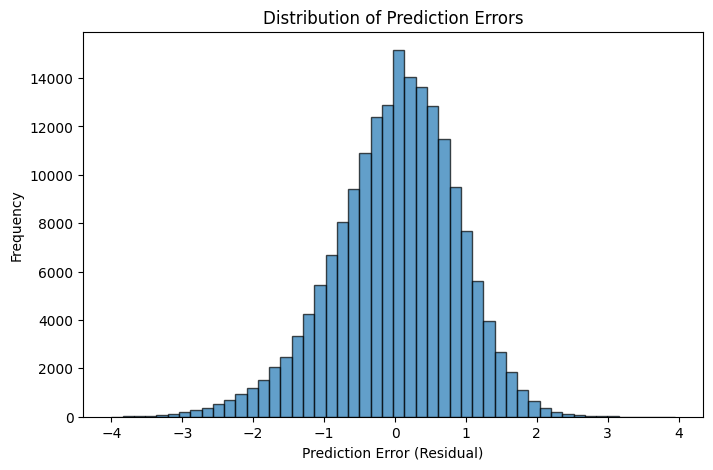

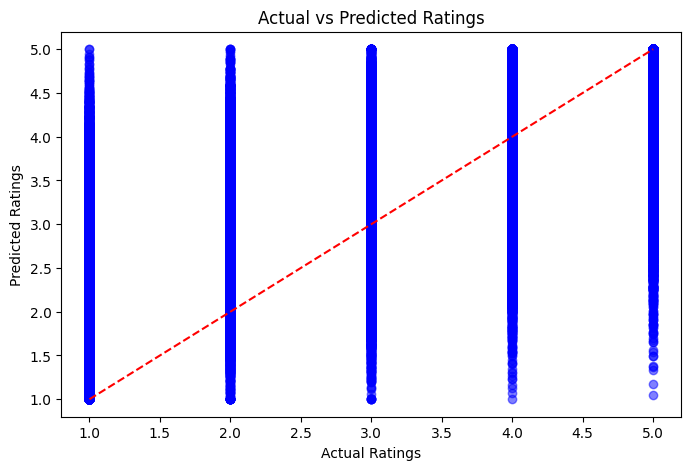

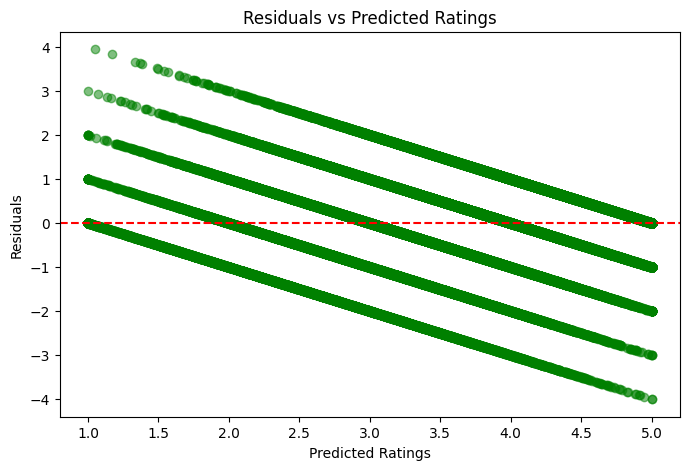

Mean Absolute Error (MAE): 0.6812
Root Mean Squared Error (RMSE): 0.8688


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from surprise import SVD, Dataset, Reader
from surprise.model_selection import train_test_split, cross_validate
from sklearn.metrics import mean_absolute_error, mean_squared_error

reader = Reader(rating_scale=(df_filtered['Rating'].min(), df_filtered['Rating'].max()))
data = Dataset.load_from_df(df_filtered[['UserID', 'Cleaned_Title', 'Rating']], reader)

trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

svd = SVD()
cross_validate(svd, data, cv=5, verbose=True)
svd.fit(trainset)

predictions = svd.test(testset)

y_actual = np.array([pred.r_ui for pred in predictions])
y_pred = np.array([pred.est for pred in predictions])

errors = y_actual - y_pred

plt.figure(figsize=(8, 5))
plt.hist(errors, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel("Prediction Error (Residual)")
plt.ylabel("Frequency")
plt.title("Distribution of Prediction Errors")
plt.show()

plt.figure(figsize=(8, 5))
plt.scatter(y_actual, y_pred, alpha=0.5, color='blue')
plt.plot([min(y_actual), max(y_actual)], [min(y_actual), max(y_actual)], color='red', linestyle='--')
plt.xlabel("Actual Ratings")
plt.ylabel("Predicted Ratings")
plt.title("Actual vs Predicted Ratings")
plt.show()

plt.figure(figsize=(8, 5))
plt.scatter(y_pred, errors, alpha=0.5, color='green')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel("Predicted Ratings")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Ratings")
plt.show()

mae = mean_absolute_error(y_actual, y_pred)
rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
